In [8]:
#coding=utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from tqdm import tqdm

from torch import optim
from time import gmtime, strftime
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

# from config_bdpt import input_size, root, proposalN, channels
from config import input_size, root, proposalN, channels
from utils.read_dataset_4imgs_eval import read_dataset
from utils.auto_laod_resume import auto_load_resume
from utils.utils import TrainClock, save_args, AverageMeter, AUCMeter,calculate_accuracy
# from networks.model_bdpt import MainNet
# from networks.model import MainNet
from networks.model_onlyappm_amil import MainNet_2input

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")

In [10]:
# dataset
set = 'Mura'
if set == 'CUB':
    root = './datasets/CUB_200_2011'  # dataset path
    # model path
    pth_path = "./models/cub_epoch144.pth"
    num_classes = 200
elif set == 'Aircraft':
    root = './datasets/FGVC-aircraft'  # dataset path
    # model path
    pth_path = "./models/air_epoch146.pth"
    num_classes = 100
elif set == 'Mura':
    root = r'E:\Xing\Data\MURA-v1.1'  # dataset path
    pth_path = r'C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura_onlyappm_4imgs_0213_amil_9feats_135/best_model.pth'
    num_classes = 1
elif set == 'Mura_bp':
#     model_path = './checkpoint/mura_bp_bimodel_adj0103'  # pth save path
    root = r'E:\Xing\Data\MURA-v1.1'  # dataset path
    pth_path = r'C:/Users/Xing/Projects/AirGo/MMAL-Net/checkpoint/mura_bp_bimodel_adj0103/best_model.pth'
    num_classes = 7

batch_size = 1

#load dataset
_, testloader = read_dataset(input_size, batch_size, root, set)
set

Loading Mura
Loading testset


'Mura'

In [11]:
# 定义模型
model = MainNet_2input(proposalN=proposalN, num_classes=num_classes, channels=channels)

model = model.to(DEVICE)

#加载checkpoint
if os.path.exists(pth_path):
    epoch = auto_load_resume(model, pth_path, status='test')
else:
    sys.exit('There is not a pth exist.')

Load model from C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura_onlyappm_4imgs_0213_amil_9feats_135/best_model.pth
Resume from C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura_onlyappm_4imgs_0213_amil_9feats_135/best_model.pth


In [12]:
criterion = nn.BCELoss()

In [14]:
# torch.cuda.set_device(3)
# from utils import calculate_accuracy

losses_val = AverageMeter('loss')
accuracies_val = AverageMeter('acc')
model.eval()
y = []
pred = []
study_out={}
study_label={}

#fileio.maybe_make_new_dir(result_path)
with torch.no_grad():
    for i, data in tqdm(enumerate(testloader)):
        
        if set == 'CUB':
            x, label, boxes, _ = data
        elif set == 'Mura_bp':
            x, label_bp, label,meta_data = data
        else:
            x, xs,label,meta_data = data
            
        encounter = meta_data['encounter']
        image_val = x.to(DEVICE)
        images_val = xs.to(DEVICE)
        images_val = F.interpolate(images_val, size=[448, 448])
        targets_val = label.float().to(DEVICE)
        outputs_logits = model(image_val,images_val, epoch, i, 'test', DEVICE)[1]
        outputs_val = F.sigmoid(outputs_logits)
        
#         print(targets_val.shape,outputs_val.shape)
        
#         targets_val = data['label'].float().cuda()
#         images_val = data['image'].float().cuda()
#         outputs_val = model(images_val)
        loss_val = criterion(outputs_val, targets_val)
        
#         add_gl_image_index(images_val, patches_val, outputs_val, targets_val,  writer, subset='val', epoch=0, index = j)
        
        acc_val = calculate_accuracy(outputs_val, targets_val)
        losses_val.update(loss_val.item(), targets_val.size(0))
        accuracies_val.update(acc_val, targets_val.size(0))
        y.append(targets_val.cpu().numpy())
        pred.append(outputs_val.cpu().numpy())
        
        for j in range(len(outputs_logits)):
            if study_out.get(encounter[j], -1) == -1:
                study_out[encounter[j]] = [outputs_val[j].item()]
                study_label[encounter[j]] = targets_val[j].item()
            else:
                study_out[encounter[j]] += [outputs_val[j].item()]

print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)


0it [00:00, ?it/s]C:\Users\Windows\anaconda3\envs\env_torch\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\Windows\anaconda3\envs\env_torch\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
3197it [04:29, 11.88it/s]

val_loss:  0.4714646718402496 val_acc:  0.8392242743634553


In [15]:
import numpy as np

In [16]:
st_pred = []
st_y = []
index = []
for key in study_out.keys():
    index.append(key)
    st_pred.append(np.mean(study_out[key]))
    st_y.append(study_label[key])

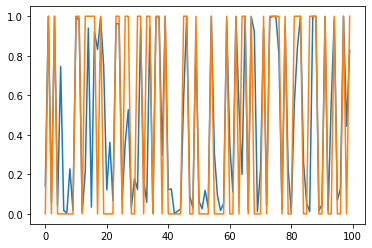

In [17]:
%matplotlib inline
plt.plot(st_pred[:100])
plt.plot(st_y[:100])

In [18]:
import numpy as np

In [19]:
y= np.asarray(y)
pred= np.asarray(pred).squeeze()

In [20]:
y= np.asarray(st_y)
pred= np.asarray(st_pred).squeeze()

In [21]:
y,pred

(array([0., 1., 0., ..., 1., 1., 0.]),
 array([0.14001675, 0.99954838, 0.05941621, ..., 0.42452106, 0.21303782,
        0.00855155]))

In [22]:
y.shape

(1199,)

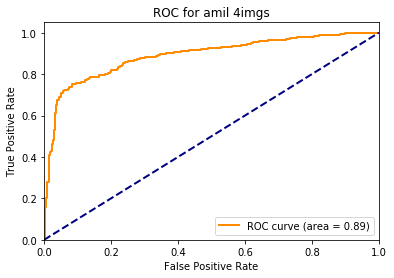

In [28]:
from sklearn import metrics

%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(y, pred)

roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for amil 4imgs')
plt.legend(loc="lower right")
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)


In [25]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y,pred_t)

0.671785981100548

In [26]:
cm[0,0]/sum(cm[0,:]), cm[1,1]/sum(cm[1,:])

(0.9152798789712556, 0.7472118959107806)

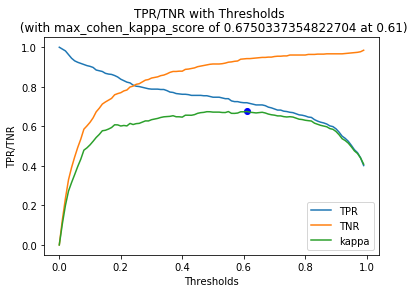

In [27]:
import numpy
from sklearn.metrics import cohen_kappa_score
mali = []
beni = []
cohen = []
tt = numpy.arange(0,1,0.01)
for thres in tt:
#     print(thres)
    pred_t = pred > thres
    pred_t.astype(int)
    cm = confusion_matrix(y,pred_t)
    mali.append(cm[1,1]/sum(cm[1,:]))
    beni.append(cm[0,0]/sum(cm[0,:]))
    cohen.append(cohen_kappa_score(y,pred_t))
# print(thresholds)
plt.figure(),plt.plot(tt,mali,label='TPR'),plt.plot(tt,beni,label='TNR'),plt.plot(tt,cohen,label='kappa')
plt.xlabel('Thresholds')
plt.ylabel('TPR/TNR')

plt.legend(loc="lower right")


net_max = cohen.index(max(cohen))
plt.title('TPR/TNR with Thresholds \n (with max_cohen_kappa_score of {} at {})'.format(max(cohen),tt[net_max]))
plt.scatter(tt[net_max], cohen[net_max], color='b')
plt.show()

In [29]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     plt.figure(figsize=(4, 3))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

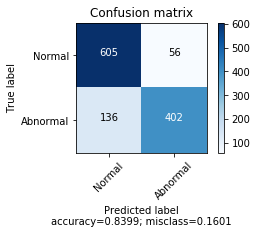

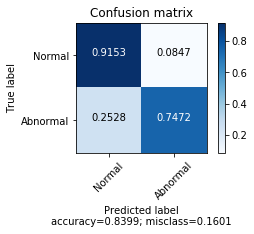

In [30]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= False)
plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= True)

In [25]:
a = 0.7

In [26]:
a>0.5

True

In [28]:
1-(a>0.50)

0

In [43]:
a = torch.rand(3,3)

In [44]:
a

tensor([[0.2847, 0.4820, 0.1940],
        [0.7670, 0.0734, 0.9933],
        [0.7518, 0.1041, 0.5967]])

In [35]:
a.shape

torch.Size([3, 3])

In [36]:
b = [0,2,1]

In [37]:
b = torch.tensor(b)

In [55]:
bb = b.reshape(-1,1)

In [54]:
b

tensor([0, 2, 1])

In [39]:
l = F.nll_loss(a,b)

In [40]:
l

tensor(-0.5024)

In [46]:
sm = nn.LogSoftmax(dim=1)

In [47]:
aa = sm(a)

In [48]:
aa

tensor([[-1.1415, -0.9442, -1.2322],
        [-1.0130, -1.7066, -0.7866],
        [-0.8669, -1.5147, -1.0220]])

In [56]:
l = F.nll_loss(aa,bb)

RuntimeError: multi-target not supported at ..\aten\src\THNN/generic/ClassNLLCriterion.c:20

In [53]:
l

tensor(1.1476)

In [59]:
a = np.random.rand(3,4)

In [66]:
b = np.random.rand(2,4)

In [72]:
t = [a,b]

In [73]:
np.array(t).shape

(2,)

In [74]:
t.pop()

array([[0.255251, 0.802925, 0.39936 , 0.069087],
       [0.192725, 0.195726, 0.765414, 0.068067]])

In [75]:
t.pop()

array([[0.269292, 0.443954, 0.016551, 0.314709],
       [0.903049, 0.930926, 0.752409, 0.969705],
       [0.035113, 0.174226, 0.025869, 0.240254]])

In [76]:
t[0]

IndexError: list index out of range